In [1]:
# --- my modules
from sample_selection import sample_selection
from proposed_algorithm import domain_invariant_unsupervised_sample_selection as diuss 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtply
import pandas as pd
import scipy as sp
import scipy.io as sp_io
from scipy.spatial.distance import cdist


from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [3]:
mat_filename = "./1Data_Tot.mat"
data_mat = sp_io.loadmat(mat_filename, struct_as_record = False)
type(data_mat)
data_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'SET', 'Time_Sample_Tot', 'Time_White_Tot', 'Time_Dark_Tot', 'Refl_Sample_Tot', 'Trans_Sample_Tot', 'Refl_White_Tot', 'Trans_White_Tot', 'Refl_Dark_Tot', 'Trans_Dark_Tot', 'Refl_Tot', 'Trans_Tot', 'Time_Milk_Tot', 'Cow_ID_Tot', 'Milk_yield_Tot', 'Time_PrevMilk_Tot', 'Milk_Interv_Tot', 'Fat_Tot', 'Prot_Tot', 'Lact_Tot', 'Urea_Tot', 'SCC_Tot', 'pathFolder'])

### <span style="color:#00BDFF">Milk Dataset</span>

In [4]:
x0 = data_mat["Trans_Tot"]
#y0 = np.concatenate((data_mat["Fat_Tot"], data_mat["Prot_Tot"], data_mat["Lact_Tot"]), axis = 1)
y0 = data_mat["Lact_Tot"]
n0 = x0.shape[0]

all_samples = np.arange(n0)
complete_samples = np.where(np.isnan(y0).sum(axis=1) == 0)[0]

x = x0[complete_samples,:]
y = y0[complete_samples,:]
n = x.shape[0]
week = data_mat["SET"][complete_samples]

x_w1 = x[(week == 1).flatten(),:]
y_w1 = y[(week == 1).flatten(),:]
x_w2 = x[(week == 3).flatten(),:]
y_w2 = y[(week == 3).flatten(),:]

n_w2 = x_w2.shape[0]

# use only week 1 as calibration  and week 2 as test set  and lactose as Y variable

### <span style="color:#00BDFF">Setting calibration and test datasets</span>

In [5]:
x_all = x_w1 
print(x_all.shape)
y_all = y_w1
print(y_all.shape)

x_test = x_w2 
print(x_test.shape)
y_test = y_w2
print(y_test.shape)

(316, 256)
(316, 1)
(79, 256)
(79, 1)


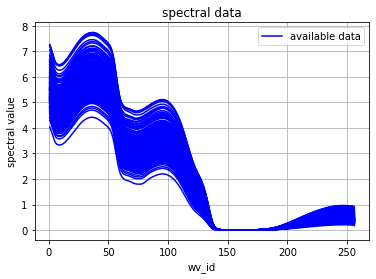

In [6]:
# visualize data
wv_range = np.arange(1,x_all.shape[1]+1) 
plt.plot(wv_range,x_all[0], c = "blue", label = "available data") #(Row 1)
plt.plot(wv_range,x_all.T, c = "blue") #.T is the transpose matrix (Column 1)
plt.xlabel("wv_id")
plt.ylabel("spectral value")
plt.title("spectral data")
plt.legend()
plt.grid()
plt.show()

In [7]:
# initial pca for exploratory analysis
pca_mu = x_all.mean(axis=0)  # mean(axis=0) is an array with the mean per column

X_c = x_all - pca_mu #Mean centering X_initial
X_c_t = np.ascontiguousarray(X_c.transpose()) 
cov_X = X_c_t.dot(X_c)/X_c.shape[0] # ([X_c^T]*[[X_c]) / n ; 
svd_cov_X = np.linalg.svd(cov_X) # Singular Value Decomposition

chosen_pc = 25 #sugested number 

pc_loadings = svd_cov_X[0][:,0:chosen_pc] # first 25 coulums from left eigenvectors U
tscores = (x_all - pca_mu).dot(pc_loadings) #X centered * Loadings
x_all_predicted = tscores.dot(pc_loadings.T) + pca_mu

q_residuals = np.mean(np.power(x_all - x_all_predicted,2),axis=1) # Mean per row of (Xi -Xp)^2
hotelling_t2 = np.diag(tscores.dot(np.diag(1/svd_cov_X[1][0:chosen_pc])).dot(tscores.T)) 
#Dig( tscores(155,10)* Dia(1/SVD_Cov_X(650,1))*tscores^T)

print("proportion of variance first pc's: ",np.round(svd_cov_X[1]/np.sum(svd_cov_X[1]),6)[0:chosen_pc])
# Eigenvalue(i)/Sum(Eigenvalues)
# Eigenvalues = expalined variance

proportion of variance first pc's:  [9.93616e-01 5.75800e-03 4.31000e-04 1.36000e-04 3.30000e-05 1.10000e-05
 8.00000e-06 3.00000e-06 2.00000e-06 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00]


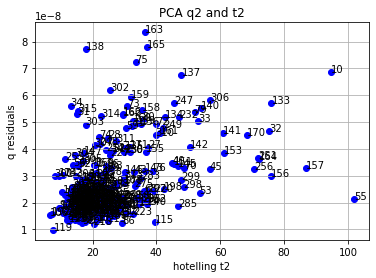

In [8]:
plt.scatter(hotelling_t2,q_residuals,c="blue")
for ii in range(hotelling_t2.shape[0]):
    plt.text(hotelling_t2[ii],q_residuals[ii], str(ii))
plt.grid()

plt.xlabel("hotelling t2")
plt.ylabel("q residuals")
plt.title("PCA q2 and t2")
plt.show()

In [ ]:
# --- observations to carry for unsupervised sample selection if necessary
#samples_initial_id = np.arange(0,len(x_all))
#drop_obs = [10,55,157] 
#keep_obs = [ii for ii in range(x_all.shape[0]) if ii not in drop_obs]

#x_all_keep = np.delete(x_all, obj = drop_obs, axis=0)
#samples_all_id = samples_initial_id[keep_obs]

#y_all_keep = np.delete(y_all, obj = drop_obs, axis=0)

#print(x_all_keep.shape)
#print(y_all_3.shape)

In [ ]:
#Exporting calibration data to use in R
CAL_X= pd.DataFrame(x_all)
CAL_X.to_excel('1x_all_milk.xlsx', sheet_name='sheet1', index=False)
CAL_X

# <span style="color:#00BDFF">unsupervised sample selection</span>

In [9]:
# --- determine optimal complexity
d = 16 # number of lv
n_sel = 90
a = 25 # number of pc 

print("n: ", n_sel)
print("a: ", a)

n:  90
a:  25


In [10]:
my_sample_selection = sample_selection(x_all, ncp = a)  
my_sample_selection

## Z matrix for Diuss Method

In [11]:
sub_samples = diuss.sub_matrix(x_matrix = x_all, num_samples=n_sel)
Z=sub_samples[0]
X_minus_Z=sub_samples[1]
Z_samples=sub_samples[2]
X_minus_Z_samples=sub_samples[3]

Z= element [0] dimetion: (90, 256) numpy.ndarray
Y= element [1] dimetion: (226, 256) numpy.ndarray
Zsamples= element [2] length: 90 numpy.ndarray
Ysamples= element [3] length: 226 numpy.ndarray


## State of the art Methods

In [12]:
# The DOE selection method was performed in R using PCA and optFederov functions
DOE = [ 1, 3, 8, 10, 12, 27, 32, 33, 40, 43, 45, 48, 53, 55, 59, 64, 
        70, 71, 73, 75, 76, 79, 80, 84, 86, 103, 115, 133, 134, 135, 
        136, 137, 139, 140, 141, 142, 143, 145, 151, 153, 154, 156, 157, 
        161, 162, 163, 164, 165, 168, 170, 171, 185, 187, 191, 193, 198, 
        203, 212, 218, 220, 223, 232, 237, 239, 240, 241, 242, 247, 249, 
        250, 251, 252, 256, 269, 271, 275, 281, 282, 283, 284, 285, 288, 
        296, 297, 298, 299, 302, 306, 310, 312]

DOE = np.array(DOE)
DOE.shape

(90,)

In [13]:
Z_DOE= np.zeros(len(x_all),dtype=int)

for i in range(len(Z_DOE)):  
    if i in DOE:
        Z_DOE[i] = 1
Z_DOE

array([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,

In [14]:
# --- select samples

my_sample_selection = sample_selection(x_all, ncp = a)  
my_sample_selection.get_xcal_pca_scores()

selected_sets = {}

selected_sets["ks_sample"] = my_sample_selection.kennard_stone(Nout=n_sel, fixed_samples=None, use_pca_scores=True,distance_metric='mahalanobis')
selected_sets["duplex_sample"] = my_sample_selection.duplex(Nout = n_sel, use_pca_scores=True, distance_metric='mahalanobis')
selected_sets["puch_sample"] = my_sample_selection.puchwein(Nout = n_sel, factor_k=0.0001, use_pca_scores=True, distance_metric='mahalanobis')
selected_sets["clus_sample"] = my_sample_selection.clustering(Nout = n_sel , use_pca_scores=True, distance_metric='euclidean', linkage = "complete")
selected_sets["all_samples"] = np.full(len(x_all), 1, dtype=int)
selected_sets["DOE"] = Z_DOE

## Diuss Method

In [15]:
#Diuss using max sigmas from SVD
best_max=diuss.diuss_max(X = x_all, Z = Z, Y = X_minus_Z, Z_samples = Z_samples,
                         Y_samples = X_minus_Z_samples, iterations=4000)
#Diuss using sum of sigmas from SVD
best_sum=diuss.diuss_sum(X = x_all, Z = Z, Y = X_minus_Z, Z_samples = Z_samples,
                         Y_samples = X_minus_Z_samples, iterations=4000)

In [16]:
selected_sets["diuss_max"] = best_max[5]
selected_sets["diuss_sum"] = best_sum[5]

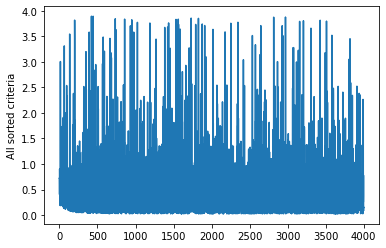

In [17]:
#The criterion shows convergence diuss_max
diuss.crit_behavior(all_crit = best_max[4])

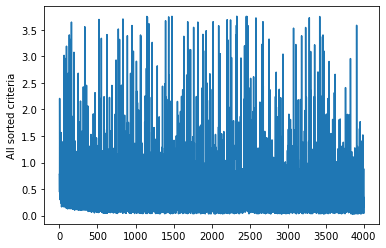

In [18]:
#The criterion shows convergence diuss_sum
diuss.crit_behavior(all_crit = best_sum[4])

In [19]:
print("KS: ",selected_sets["ks_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["ks_sample"]))
print("Duplex: ",selected_sets["duplex_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["duplex_sample"]))
print("puch_sample: ",selected_sets["puch_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["puch_sample"]))
print("clus_sample: ", selected_sets["clus_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["clus_sample"]))
print("diuss_max:",selected_sets["diuss_max"],"total_samples:",diuss.count_of_ones(array = selected_sets["diuss_max"]))
print("diuss_sum:",selected_sets["diuss_sum"],"total_samples:",diuss.count_of_ones(array = selected_sets["diuss_sum"]))
print("DOE:",selected_sets["DOE"],"total_samples:",diuss.count_of_ones(array = selected_sets["DOE"]))
print("all_samples:",selected_sets["all_samples"],"total_samples:",diuss.count_of_ones(array = selected_sets["all_samples"]))

KS:  [0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0
 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1
 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0
 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1
 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0] total_samples: 90
Duplex:  [0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 1 1
 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0
 0 1 1 1 1 0 1 0 0 1 0 1 1

In [20]:
def sample_list(method_samples):
    l = len(method_samples)
    r=np.zeros((), dtype=int)

    for i in range(l):
        if method_samples[i] == 1:
            r=np.append(r,i)
    r=r[1:] # To eleiminate the first 0 from np.Zeros
    return(r)

In [21]:
Ks = sample_list(method_samples=selected_sets["ks_sample"])
dup = sample_list(method_samples=selected_sets["duplex_sample"])
puch = sample_list(method_samples=selected_sets["puch_sample"])
clus = sample_list(method_samples=selected_sets["clus_sample"])
d_max = sample_list(method_samples=selected_sets["diuss_max"])
d_sum = sample_list(method_samples=selected_sets["diuss_sum"])

In [22]:
# Samples ID from 0 to 315 for a total n=316
print("ks")
print(Ks)
print("dup")
print(dup)
print("puch")
print(puch)
print("clus")
print(clus)
print("d_max")
print(d_max)
print("d_sum")
print(d_sum)
print("DOE")
print(DOE)

ks
[  1   8  10  12  23  27  30  32  33  40  44  45  48  51  53  55  62  64
  68  70  71  72  73  75  76  78  79  80  81  84  86  90 106 133 134 135
 136 137 139 140 141 142 143 145 146 151 153 154 155 156 157 158 159 160
 161 162 163 164 165 170 171 198 209 220 227 240 242 247 249 250 251 252
 256 269 271 275 281 282 285 290 291 295 298 299 303 306 310 311 312 313]
dup
[  8   9  10  12  15  20  23  27  30  32  41  44  48  51  53  55  58  62
  64  66  69  71  72  73  74  77  79  80  84  90  93  96  99 101 112 136
 138 139 140 141 144 149 150 151 152 154 157 159 160 165 166 168 169 170
 172 179 189 194 198 210 215 216 220 226 233 236 239 240 249 250 251 252
 258 260 269 271 275 278 282 283 285 288 290 291 297 299 306 310 311 312]
puch
[  1   4   8  10  12  27  30  32  33  40  44  45  51  53  55  58  62  64
  68  70  72  73  74  75  76  78  79  80  81  84  86 133 134 135 136 137
 139 140 141 142 143 145 146 151 153 155 156 157 158 159 160 161 162 163
 164 165 170 171 185 186 188 191 198 

In [23]:
# --- select one sample set for cal and eigenevaluation
svd_methods = {} # dictionary
# [] is a list

for method_name in selected_sets.keys():    

    selected_cal_set = selected_sets[method_name].copy()

    # --- evaluate selected cal set: S matrix eigen decomp

    
    x_selected = x_all[selected_cal_set==1,:]
    Xs_c = x_selected - x_selected.mean(axis=0)
    Xs_c_t = np.ascontiguousarray(Xs_c.transpose())
    cov_Xs = Xs_c_t.dot(Xs_c)/Xs_c.shape[0]
    svd_selected = np.linalg.svd(cov_Xs)
    
    svd_methods[method_name] = svd_selected
    
print("done")

done


determinant eigenvectors: 

ks_sample :  0.336
duplex_sample :  0.475
puch_sample :  0.346
clus_sample :  0.36
all_samples :  1.0
DOE :  0.118
diuss_max :  0.423
diuss_sum :  0.347


<ipython-input-24-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-24-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-24-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-24-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-24-695fb3db0d93>:34: 

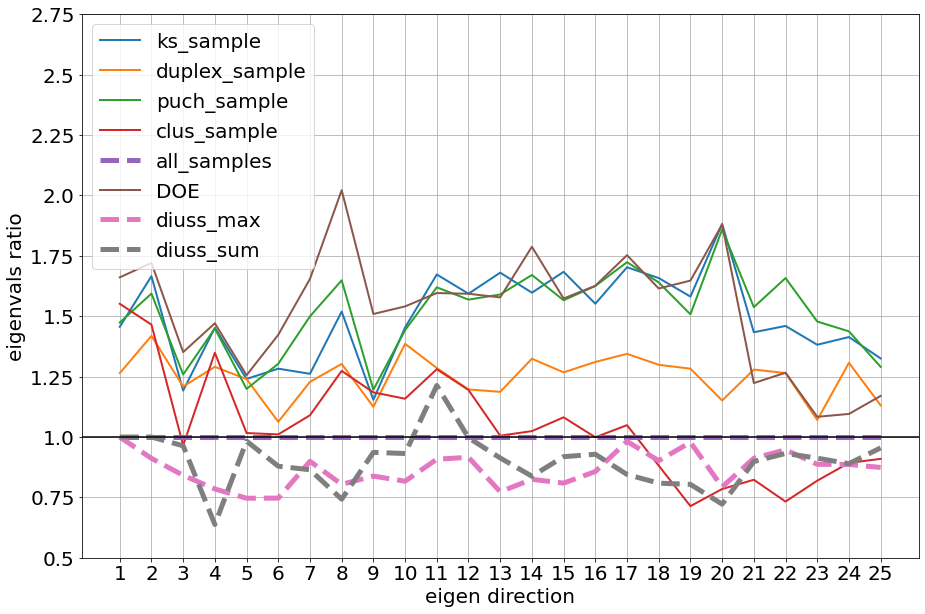

In [24]:
# --- visualize comparison svd
X_c = x_all - x_all.mean(axis=0)
X_c_t = np.ascontiguousarray(X_c.transpose())
cov_X = X_c_t.dot(X_c)/X_c.shape[0]
svd_cov_X = np.linalg.svd(cov_X)

# eigenvect comparison

print("determinant eigenvectors: \n")

for method_name in svd_methods.keys():
    
    svd_selected = svd_methods[method_name]
    eigen_vals_ratio = svd_selected[1][0:a]/svd_cov_X[1][0:a]
    eigen_vect_comparison = svd_selected[0][:,0:a].T.dot(svd_cov_X[0][:,0:a])
    eigen_vect_criterion = np.abs(np.linalg.det(eigen_vect_comparison))
    print(method_name,": ",np.round(eigen_vect_criterion,3))
    
    
# eigenval comparison

font_size = 20
yticks = np.arange(0.5,3, 0.25)
xticks = np.arange(1,a+1)


fig, ax = plt.subplots(figsize = (15,10))

for method_name in svd_methods.keys():
    
    svd_selected = svd_methods[method_name]
    eigen_vals_ratio = svd_selected[1][0:a]/svd_cov_X[1][0:a]
    if method_name =="diuss_max" or method_name =="diuss_sum" or method_name =="all_samples" :
        ax.plot(xticks,eigen_vals_ratio, Linewidth =5 , label = method_name, linestyle='dashed')
    else:
        ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)

        
    
ax.grid()
ax.axhline(y=1, c = "black")
ax.set_xlabel("eigen direction", fontsize = font_size)
ax.set_xticks(xticks)
ax.set_xticklabels(labels = xticks, fontsize = font_size)
ax.set_ylabel("eigenvals ratio", fontsize = font_size)
ax.set_yticks(yticks)
ax.set_yticklabels(labels = yticks, fontsize = font_size)
ax.legend(fontsize = font_size)
plt.show()

## Cross validation PLSR model 

In [25]:
total_lv = 20
n_splits_cv = 10
n_shuffles = 1

In [26]:
model_evaluation = {}

for method_name in selected_sets.keys():
    
    selected_cal_set = selected_sets[method_name]
    xcal_pls = x_all[selected_cal_set==1,:]
    ycal_pls= y_all[selected_cal_set==1,:]
    
    parameters = {'n_components': list(range(1,total_lv+1))}
    pls_scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}
    
    for nn in range(n_shuffles):

        pls_cv = KFold(n_splits=n_splits_cv, shuffle=True)
        my_pls = PLSRegression(scale=False)
        my_pls_cv = GridSearchCV(my_pls, parameters, cv = pls_cv, scoring = pls_scoring, refit = False)
        my_pls_cv.fit( xcal_pls,  ycal_pls)
        
    model_evaluation[method_name] = {"rmsecv":-1*my_pls_cv.cv_results_["mean_test_rmse"],
                                    "r2cv":my_pls_cv.cv_results_["mean_test_r2"],
                                    }    
    # Note check this -1

<ipython-input-27-38b891b86173>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-27-38b891b86173>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-27-38b891b86173>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-27-38b891b86173>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange

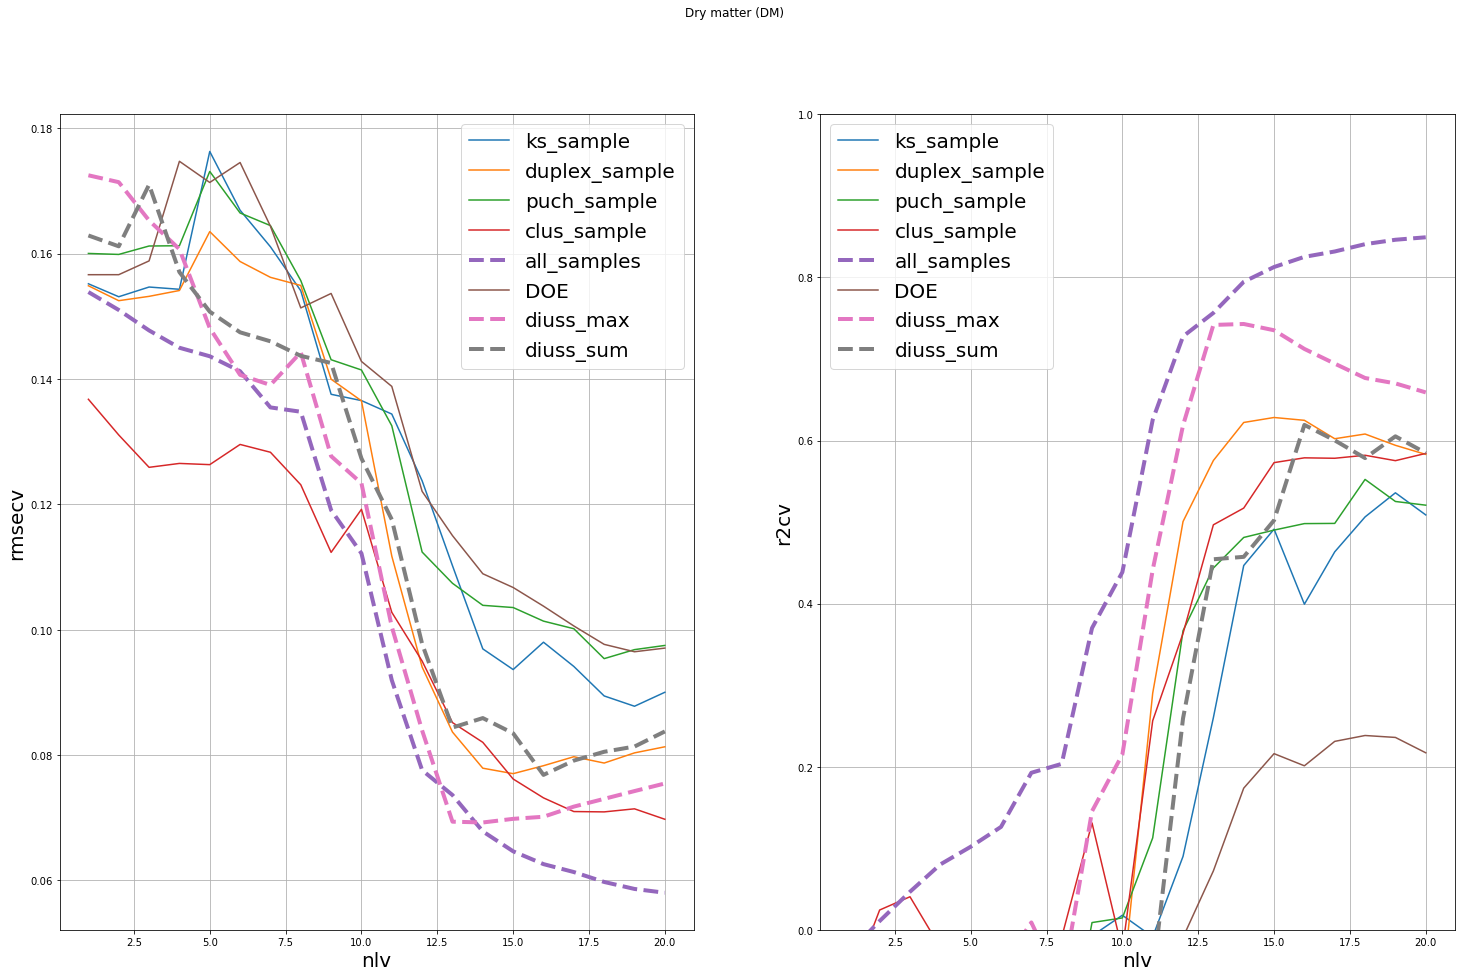

In [27]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25,15))

for method_name in model_evaluation.keys():

    rmsecv = model_evaluation[method_name]["rmsecv"]
    r2cv = model_evaluation[method_name]["r2cv"]

    if method_name =='diuss_max' or method_name =='diuss_sum' or method_name =='all_samples'  :
        ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
        ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name, Linewidth =4,linestyle='dashed')        
    else:
        ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name)
        ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("rmsecv", fontsize = font_size)
ax[1].set_ylabel("r2cv", fontsize = font_size)

ax[1].set_ylim([0,1])   

ax[0].grid()
ax[1].grid()

ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

y_name = "Dry matter (DM)"
fig.suptitle(y_name)

plt.show()

## PLSR

In [28]:
model_evaluation2 = {}

for method_name in selected_sets.keys():
    rmsep_all = np.zeros(total_lv)
    r2p_all = np.zeros(total_lv)
    
    selected_cal_set = selected_sets[method_name]
    xcal_pls = x_all[selected_cal_set==1,:]
    ycal_pls= y_all[selected_cal_set==1,:]
    xtest_pls = x_test
    ytest_pls= y_test
        
    for ii, chosen_lv in enumerate(range(1,total_lv+1)):
        
        my_pls = PLSRegression(n_components = chosen_lv,scale=False)
        my_pls.fit(xcal_pls, ycal_pls)
        x_mean = xcal_pls.mean(axis=0)
        y_mean = ycal_pls.mean(axis=0)
        
        # deliver model
        B = my_pls.coef_
        beta = y_mean - (x_mean.dot(B))

        ytest_pls_pred = xtest_pls.dot(B) + beta
        rmsep_all[ii] = np.sqrt(mean_squared_error(ytest_pls, ytest_pls_pred))
        r2p_all[ii] = r2_score(ytest_pls, ytest_pls_pred)
        
    model_evaluation2[method_name] = {"rmsep":rmsep_all,
                                    "r2p":r2p_all,
                                    }    

<ipython-input-30-2c99d386248f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-30-2c99d386248f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-30-2c99d386248f>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-30-2c99d386248f>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1,

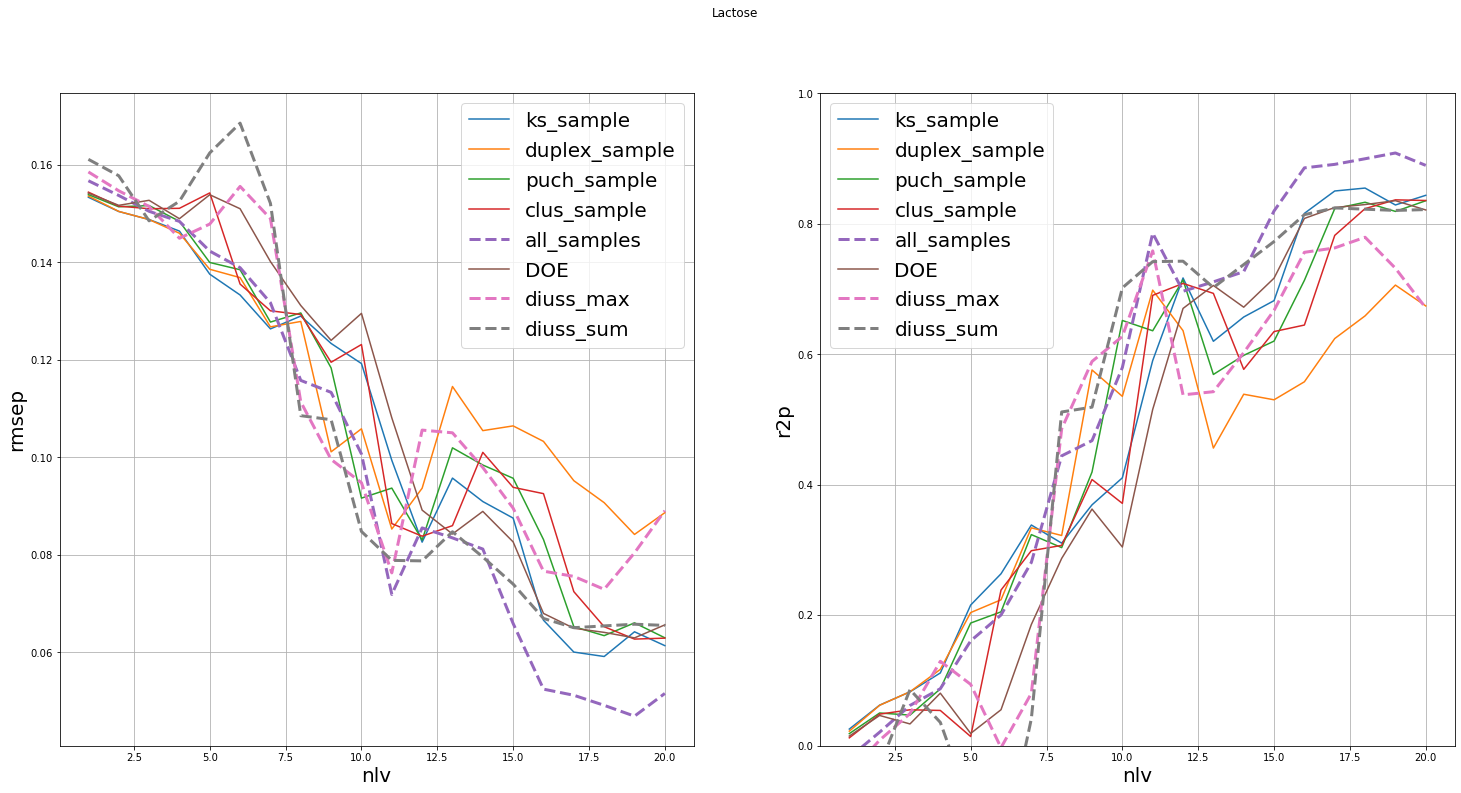

In [30]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25,12))

for method_name in model_evaluation2.keys():

    rmsep = model_evaluation2[method_name]["rmsep"]
    r2p = model_evaluation2[method_name]["r2p"]

    if method_name =='diuss_max' or method_name =='diuss_sum' or method_name =='all_samples'  :
        ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
        ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name, Linewidth =3,linestyle='dashed')        
    else:
        ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name)
        ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("rmsep", fontsize = font_size)
ax[1].set_ylabel("r2p", fontsize = font_size)

ax[1].set_ylim([0,1])   

ax[0].grid()
ax[1].grid()

ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

y_name = "Lactose"
fig.suptitle(y_name)

plt.show()
